In [19]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import bundles
from pingouin import partial_corr
from statannotations.Annotator import Annotator

bundles.beamer_moml()
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (10,8)})

from src.config import dir_rawdata, dir_prep, dir_plots_group_cmpr, cfg_colors
from src.utl import remove_outliers_df, get_log_ax, convert_pvalue_to_asterisks


## load data
Load the preprocessed data from pupils, force sensor and clinical data

In [4]:
dat_pupil = pd.read_csv(Path.joinpath(dir_prep,"all_trials_pupil.csv"), index_col=False)
dat_gss = pd.read_csv(Path.joinpath(dir_prep,"all_trials_gss.csv"), index_col=False)

print(list(dat_pupil.columns))

dat_clin = pd.read_excel(Path.joinpath(dir_rawdata,"behav_data.xlsx"), index_col=False)


['ID', 'Trial n', 'Feedback type', 'Feedback angle', 'Pupil size', 'Percentage bad pupil samples', 'Group']


## Review clinical data

In [5]:
# clean data
all = dat_clin[dat_clin["ID"].str.contains("p2|c3")]
all["group"] = all.ID.str[0]
print(list(all.columns))

all.to_csv(Path.joinpath(dir_prep,"overview_cohort.csv"))

['ID', 'Alter', 'Geschlecht', 'Krankheitsdauer', 'BDI-Score', 'Schahmann semantische Wortflüssigkeit', 'Schahmann phonematische Wortflüssigkeit', 'Schahmann Kategorie-Wechsel', 'Schahmann Zahlen-spanne vorwärts', 'Schahmann Zahlen-spanne rückwärts', 'Schahmann Würfel ', 'Schahmann verbaler Abruf', 'Schahmann Gemeinsam-keiten', 'Schahmann Go/No-Go', 'Schahmann Affekt', 'Schahmann Gesamtwert Aufgaben', 'Schahmann Gesamtwert Module', 'Tetras Sprechen', 'Tetras mit dem Löffel essen', 'Tetras aus einem Glas trinken', 'Tetras Körper-hygiene', 'Tetras Ankleiden', 'Tetras Schütten/Ein-schenken', 'Tetras Tablett tragen', 'Tetras Schlüssel benutzen', 'Tetras Schreiben', 'Tetras Arbeiten', 'Tetras Tätigkeit mit schwerster Beeinträchti-gung', 'Tetras Grad der Beeinträchti-gung ', 'Tetras soziale Beeinträchti-gung', 'Tetras Gesamtscore Interview', 'Tetras Kopftremor', 'Tetras Gesichts-tremor', 'Tetras Stimm-tremor', 'Tetras Tremor OE ausgestreckt RE', 'Tetras Tremor OE ausgestreckt LI', 'Tetras Tre

In [6]:
tmp = all["group"].value_counts()
print(f"The cohort consistet of {tmp.p:2d} ET patients and {tmp.c:2d} healthy controls.")

The cohort consistet of 16 ET patients and 11 healthy controls.


In [7]:
n_female = sum(all["Geschlecht"] == "w")
per_female = n_female / len(all["Geschlecht"].dropna()) * 100
print(f"A total of {n_female} making up {per_female:2.0f} % were present in the cohort")

A total of 13 making up 50 % were present in the cohort


### Make group comparisons for clinical data
Use Mann-whitney-U test for non-normally distributed data.

In [15]:
idx_pat = all.group == "p"
idx_con = all.group == "c"

t_age, p_age = stats.mannwhitneyu(all["Alter"][idx_pat].dropna(),all["Alter"][idx_con].dropna())
t_bdi, p_bdi = stats.mannwhitneyu(all["BDI-Score"][idx_pat].dropna(),all["BDI-Score"][idx_con].dropna())
t_schahmann, p_schahmann = stats.mannwhitneyu(all["Schahmann Gesamtwert Aufgaben"][idx_pat],all["Schahmann Gesamtwert Aufgaben"][idx_con].dropna())

print(f"The age difference between the patient and healthy controls is t = {t_age:.2f}, p = {p_age:.3f}")
print(f"The BDI difference between the patient and healthy controls is t = {t_bdi:.2f}, p = {p_bdi:.3f}")
print(f"The Schmahmann total difference between the patient and healthy controls is t = {t_schahmann:.2f}, p = {p_schahmann:.3f}")


The age difference between the patient and healthy controls is t = 86.50, p = 0.147
The BDI difference between the patient and healthy controls is t = 113.50, p = 0.003
The Schmahmann total difference between the patient and healthy controls is t = 33.50, p = 0.046


In [ ]:
r, p = stats.spearmanr(all["Alter"][all.group == "p"],all["Krankheitsdauer"][all.group == "p"], nan_policy="omit")
print(f"Age and disease duration correlate with r={r:1.2f} and p={p:1.3f}")

Age and disease duration correlate with r=0.55 and p=0.040


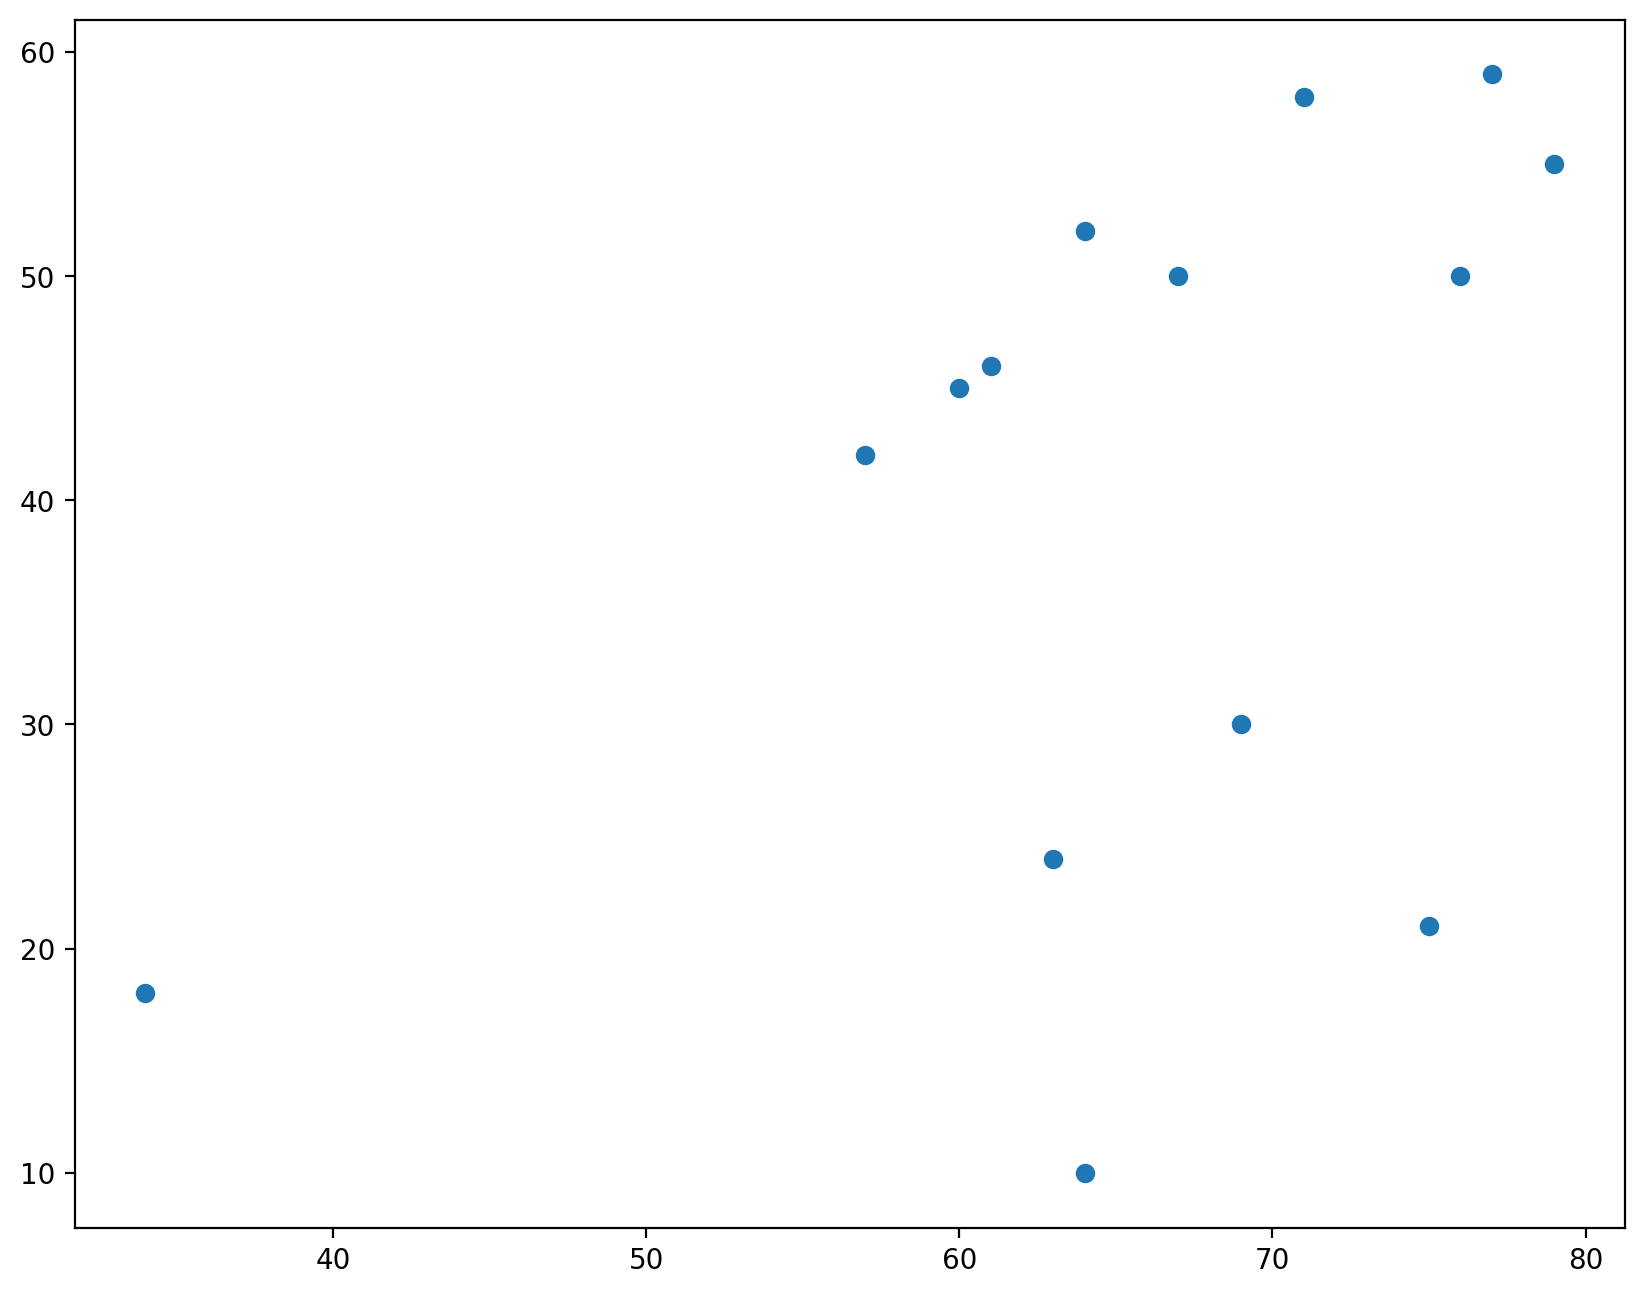

In [ ]:
plt.scatter(all["Alter"],all["Krankheitsdauer"])

In [29]:
pat = all[idx_pat]
r, p = stats.spearmanr(pat["Alter"],pat["Tetras Gesamtscore Aufgaben-skala"], nan_policy="omit")
print(f"Correlation between age and Tetras score is r = {r:.2f}, p = {p:.3f}")

Correlation between age and Tetras score is r = 0.42, p = 0.124


In [ ]:
r, p = stats.spearmanr(pat["Alter"],pat["Schahmann Gesamtwert Aufgaben"], nan_policy="omit")
print(f"Correlation between age and Schahmann score is r = {r:.2f}, p = {p:.3f}")

Correlation between age and Schahmann score is r = -0.24, p = 0.002


### Check partial correlation of Schahmann and TETRAS corrected for age

In [ ]:
# corr schahmann tetras
r, p = stats.spearmanr(pat["Tetras Gesamtscore Aufgaben-skala"],pat["Schahmann Gesamtwert Aufgaben"], nan_policy="omit")
print(f"Correlation between Tetras total and Schahmann ex total is r = {r:.2f}, p = {p:.5f} ")
print(' ')

dat_cor = pat[["Schahmann Gesamtwert Aufgaben","Tetras Gesamtscore Aufgaben-skala","Alter"]].copy()
dat_cor = dat_cor.rename(columns=lambda x: x.split(' ')[0])
corrmatR = dat_cor.corr(method='spearman')
print(corrmatR)

pc = partial_corr(data = dat_cor, x='Schahmann', y='Tetras', covar=['Alter'], method='spearman').round(4)
print(' ')
print(pc)

Correlation between Tetras total and Schahmann ex total is r = -0.21, p = 0.46094 
 
           Schahmann    Tetras     Alter
Schahmann   1.000000 -0.214758 -0.235683
Tetras     -0.214758  1.000000  0.572687
Alter      -0.235683  0.572687  1.000000
 
           n       r          CI95%   p-val
spearman  14 -0.1001  [-0.62, 0.48]  0.7448


## Merge clincal and experimental data

In [30]:
full_set = all.merge(dat_gss)
idx_pat = full_set.group == "p"

pat = full_set[idx_pat]
r, p = stats.spearmanr(pat["Alter"],pat["Power [4-12]"], nan_policy="omit")
print(f"Correlation between age and power [4-12Hz] is r = {r:.2f}, p = {p:.3f} ")

Correlation between age and power [4-12Hz] is r = 0.18, p = 0.016 


## High delta tremor to pupil

In [31]:
pat_all = pd.merge(pat,dat_pupil)


In [18]:
r, p = stats.spearmanr(pat_all["Schahmann Gesamtwert Aufgaben"],pat_all["Pupil size"], nan_policy="omit")
print(f"Correlation between Schahmann and Pupil size is r = {r:.2f}, p = {p:.3f} ")

Correlation between Schahmann and Pupil size is r = 0.05, p = 0.533 


In [19]:

diffs = pat_all.pivot_table(index=['ID','Group','Feedback type'],columns='Feedback angle',values=['Power [4-12]','Pupil size'],margins=False,aggfunc='mean').reset_index()
diffs['dPower'] = diffs['Power [4-12]']['high']-diffs['Power [4-12]']['low']
diffs['dPpl'] = diffs['Pupil size']['high']-diffs['Pupil size']['low']
diffs['dPower'] = abs(diffs['dPower'])

In [20]:
r, p = stats.spearmanr(diffs["dPower"],diffs["dPpl"], nan_policy="omit")
print(f"Correlation between change in power [4-12Hz] and change in pupil size is r = {r:.2f}, p = {p:.3f} ")


Correlation between change in power [4-12Hz] and change in pupil size is r = 0.21, p = 0.159 


## Only consider patients with severe change in Pupil size

In [21]:
diffs["dPower"].describe()

idx_cutoff_dPower = np.logical_and(diffs["dPower"] > (diffs["dPower"].mean() * .1 ), diffs["dPpl"] < .5) 

Correlation between change in power [4-12Hz] and change in pupil size is r = 0.17, p = 0.462 


<AxesSubplot:xlabel='dPower', ylabel='dPpl'>

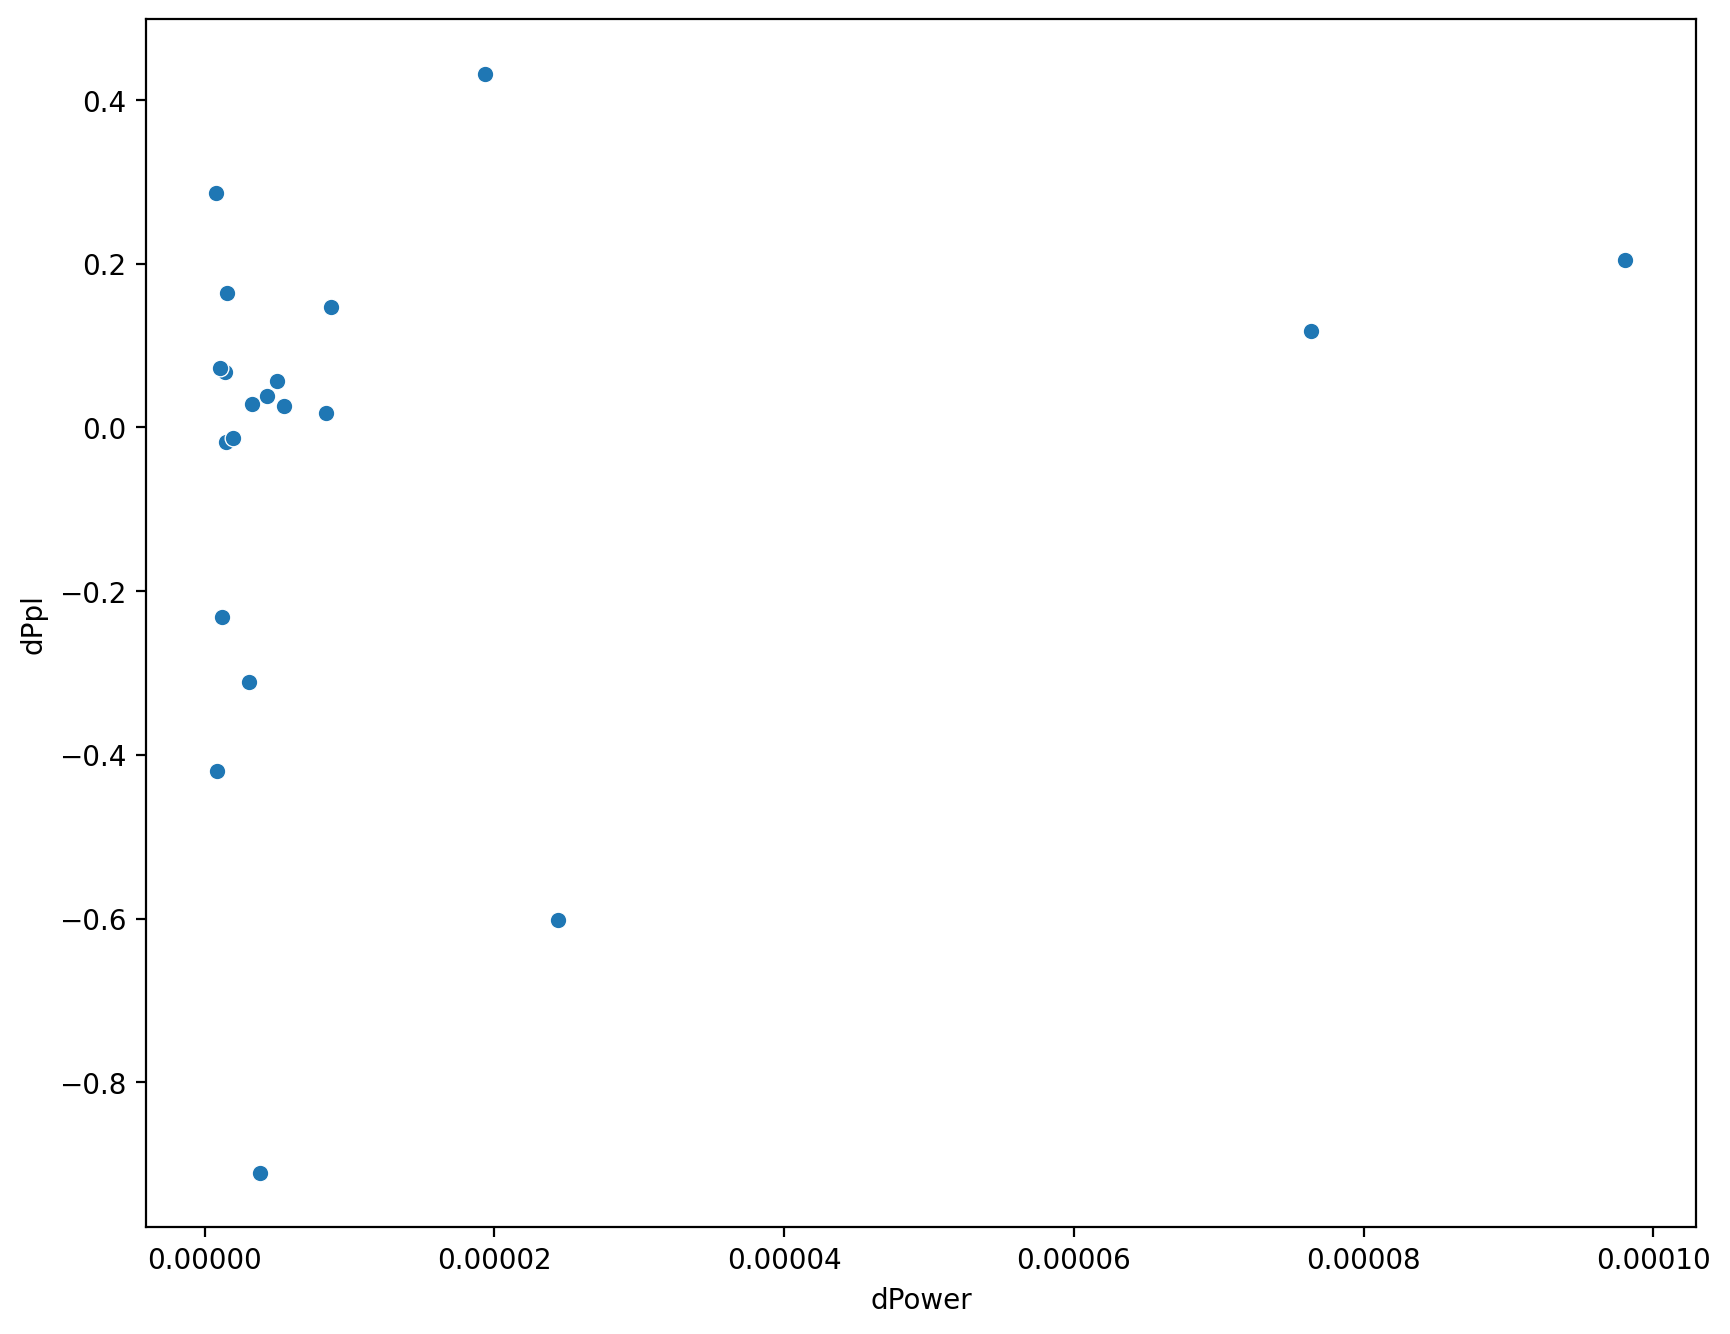

In [22]:
r, p = stats.spearmanr(diffs["dPower"][idx_cutoff_dPower],diffs["dPpl"][idx_cutoff_dPower], nan_policy="omit")
print(f"Correlation between change in power [4-12Hz] and change in pupil size is r = {r:.2f}, p = {p:.3f} ")
sns.scatterplot(data=diffs[idx_cutoff_dPower], x="dPower", y="dPpl", palette="rocket")

## Prepare Schahmann scale

In [9]:
ccas_task = dat_clin["Schahmann Gesamtwert Module"]
all = dat_clin[dat_clin["ID"].str.contains("p2|c3")]
all["group"] = all.ID.str[0]

In [10]:
idx_pat = all.group == "p"
idx_con = all.group == "c"

t_schahmann, p_schahmann = stats.mannwhitneyu(all["Schahmann Gesamtwert Module"][idx_pat],all["Schahmann Gesamtwert Module"][idx_con].dropna())

print(f"The Schmahmann module difference between the patient and healthy controls is t = {t_schahmann:.2f}, p = {p_schahmann:.3f}")


The Schmahmann module difference between the patient and healthy controls is t = 137.00, p = 0.013


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p vs. c: *


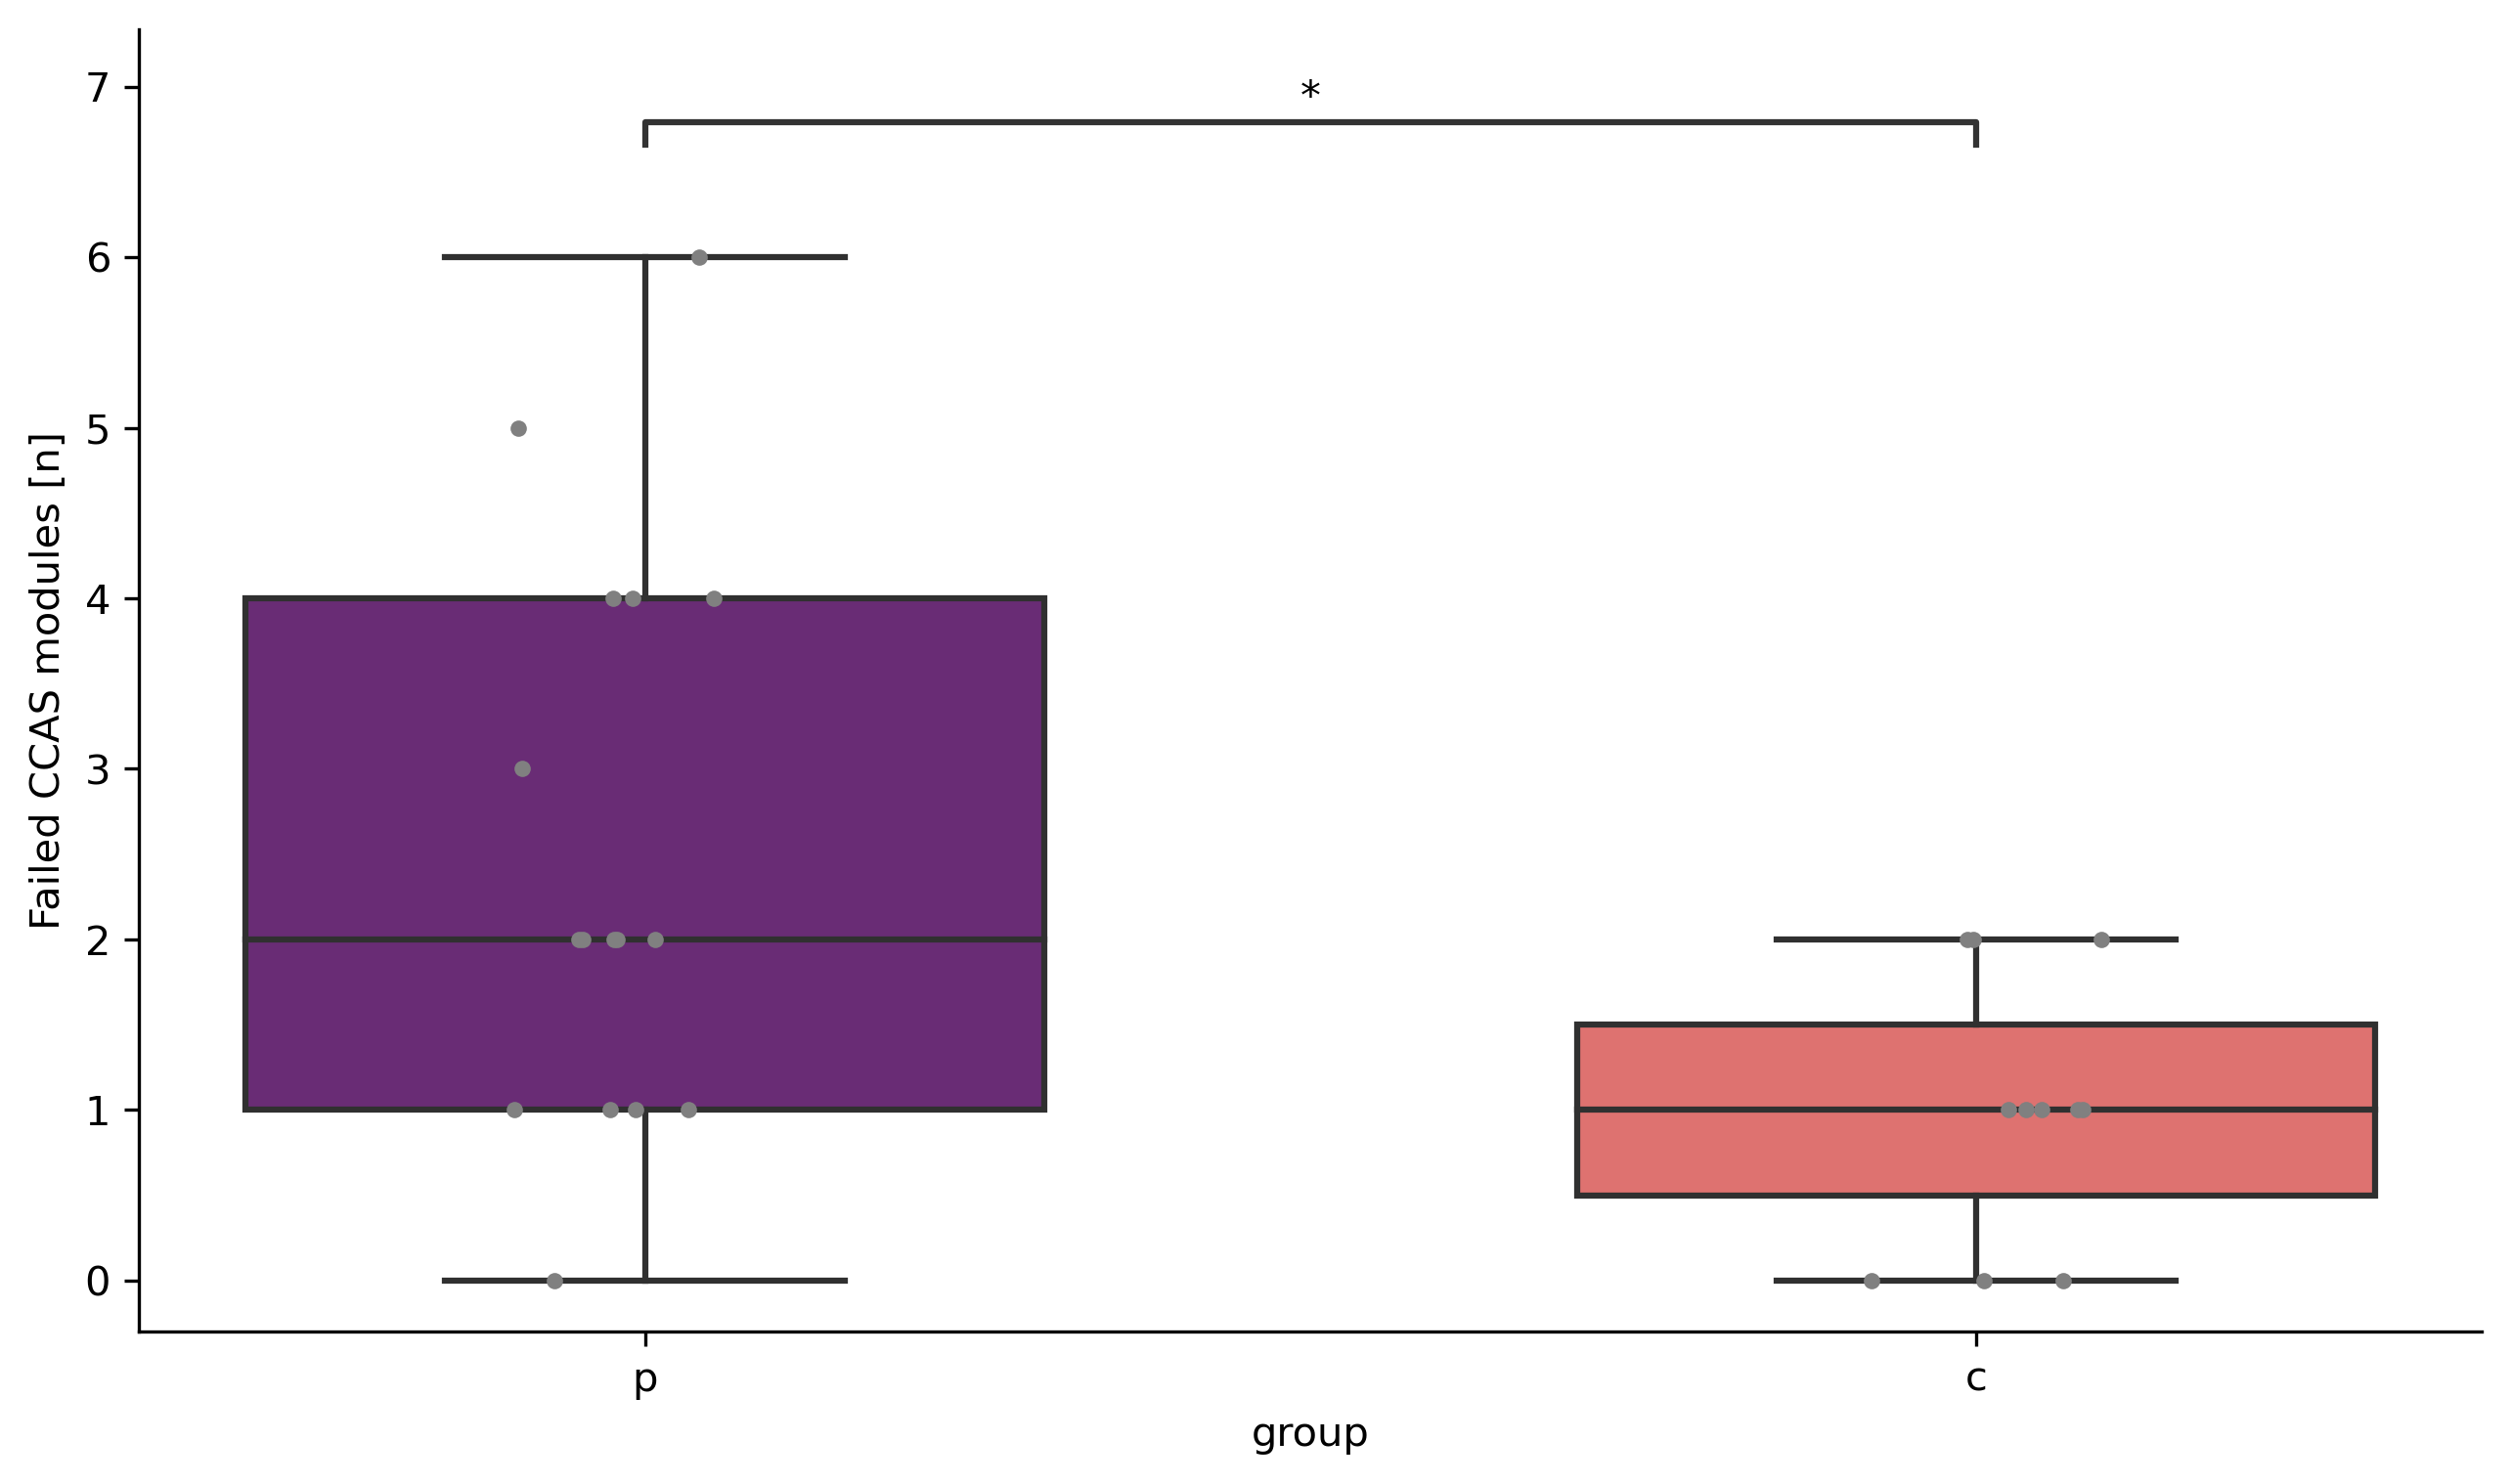

In [26]:
hue_plot_params = {
    'data' : all,
    'x' : 'group',
    'y' : 'Schahmann Gesamtwert Module',
}

pairs=[
    ("p", "c"),
]

pvalues = [p_schahmann]

# Transform each p-value to "p=" in scientific notation
start_pvalues = [convert_pvalue_to_asterisks(pvalue) for pvalue in pvalues]

fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)

# Plot with seaborn
axs = sns.boxplot(ax=axs, width=.6, palette = cfg_colors["group_colors"], fliersize=0, **hue_plot_params)
axs = sns.stripplot(ax=axs,**hue_plot_params, size=4, color=".5", linewidth=0,dodge=True)
# Add annotations
annotator = Annotator(axs, pairs, **hue_plot_params)
annotator.set_custom_annotations(start_pvalues)
annotator.annotate(line_offset_to_group=0.1)

axs.set_ylabel(r"Failed CCAS modules [n]")
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

sns.despine(fig=fig)
fig.savefig(Path.joinpath(dir_plots_group_cmpr,"ccas_module.png"))

In [33]:
exp_performance = pd.read_csv(dir_prep.joinpath("overview_all_trials_archer_rep.csv"))



,ID,n,ForceCondition,Scaling,FeedbackCondition,Block,AuditiveCondition,RMSE,Outlier RMSE,Power [0-3 Hz],Power [4-12 Hz],Outlier Power,Pupilsize left,Outlier Ppl l,Pupilsize right,Outlier Ppl r,group,Scaling_str
0,c301,1,0.15,6.9,vo,training,beat_tone,27.486729,1,1.928091,3.180496,1,NaN,0,NaN,0,control,high
1,c301,2,0.15,0.4,vo,training,beat_tone,29.301332,0,1.995673,-0.466524,0,NaN,0,NaN,0,control,low
2,c301,3,0.15,0.4,vo,experiment,beat_tone,30.846928,0,-0.620027,-0.565525,0,NaN,0,NaN,0,control,low
3,c301,4,0.15,0.4,vo,experiment,beat_tone,31.728928,0,-0.621492,-0.572839,0,-0.362576,1,-0.352310,0,control,low
4,c301,5,0.15,6.9,vo,experiment,beat_tone,31.174328,0,-0.619343,-0.415051,0,0.342093,0,0.273364,0,control,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,p215,10,0.15,6.9,va,experiment,beat_tone,33.935387,0,-0.480306,-0.381183,0,-0.567234,0,-1.566913,0,patient,high
346,p215,11,0.15,0.4,ao,experiment,beat_tone,36.207085,0,-0.410396,-0.567046,0,0.823393,0,-0.642355,0,patient,low
347,p215,12,0.15,0.4,ao,experiment,beat_tone,34.619102,0,-0.369593,-0.489797,0,0.560169,0,-0.790316,0,patient,low
348,p215,13,0.15,6.9,ao,experiment,beat_tone,28.580685,1,-0.155012,3.138513,1,NaN,0,NaN,0,patient,high
